## R√©gression 
### Matrice de corr√©lation


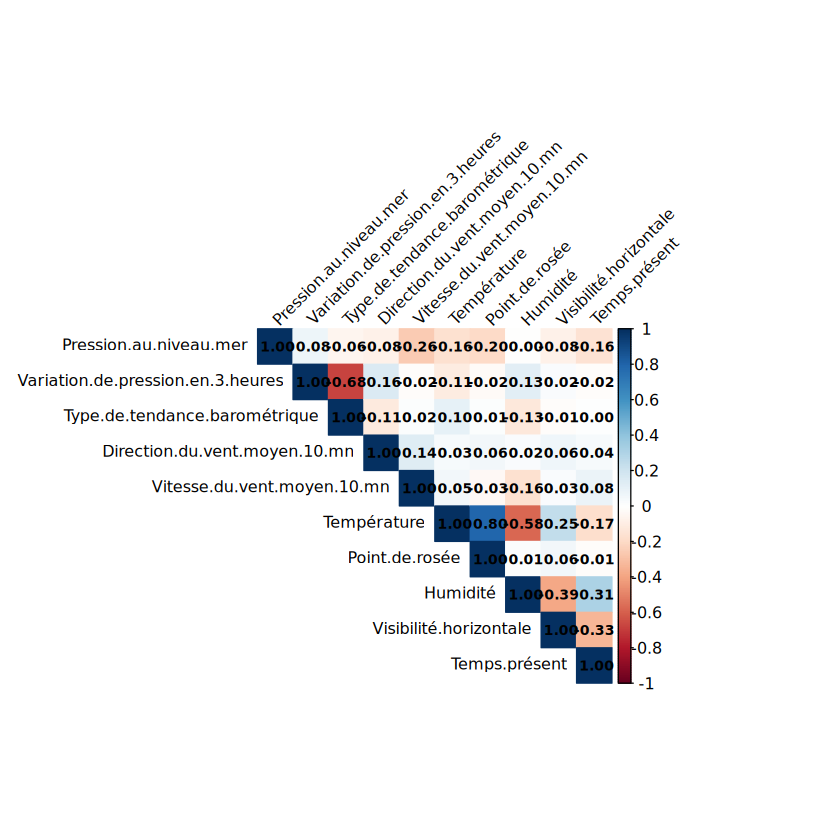

In [31]:
library(corrplot)
library(dplyr)
par(bg='white')
# S√©lectionner uniquement les colonnes num√©riques
vars_num <- data_metropole %>% 
  select(where(is.numeric))

# Garder seulement les 10 premi√®res colonnes num√©riques (optionnel)
vars_num <- vars_num[, 2:11]

# Corr√©lation
mat_cor <- cor(vars_num, use = "pairwise.complete.obs")

# Sauvegarde dans une grande image
# png("../fig/corrplot2.png", width = 1200, height = 1200, res = 150)

corrplot(mat_cor, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45, 
         tl.cex = 0.8,         # taille du texte des labels
         addCoef.col = "black", 
         number.cex = 0.7)

# dev.off()


### R√©gression simple: moy_Humidt√©_mensuelle ~ moy_Temp√©rature_mensuelle 

Afin de limiter les biais et de garantir une repr√©sentativit√© spatiale, nous avons s√©lectionn√© des stations m√©t√©orologiques √©loign√©es les unes des autres, r√©parties sur l‚Äôensemble du territoire fran√ßais :

* Nord : 7015 ‚Äì Fretin (59, Hauts-de-France)
* Centre : 7149 ‚Äì Athis-Mons (91, Essonne, √éle-de-France)
* Ouest : 7110 ‚Äì Guipavas (29, Finist√®re)
* Est : 7190 ‚Äì Holtzheim (67, Bas-Rhin)
* Sud-Ouest : 7630 ‚Äì Blagnac (31, Haute-Garonne). ¬ª

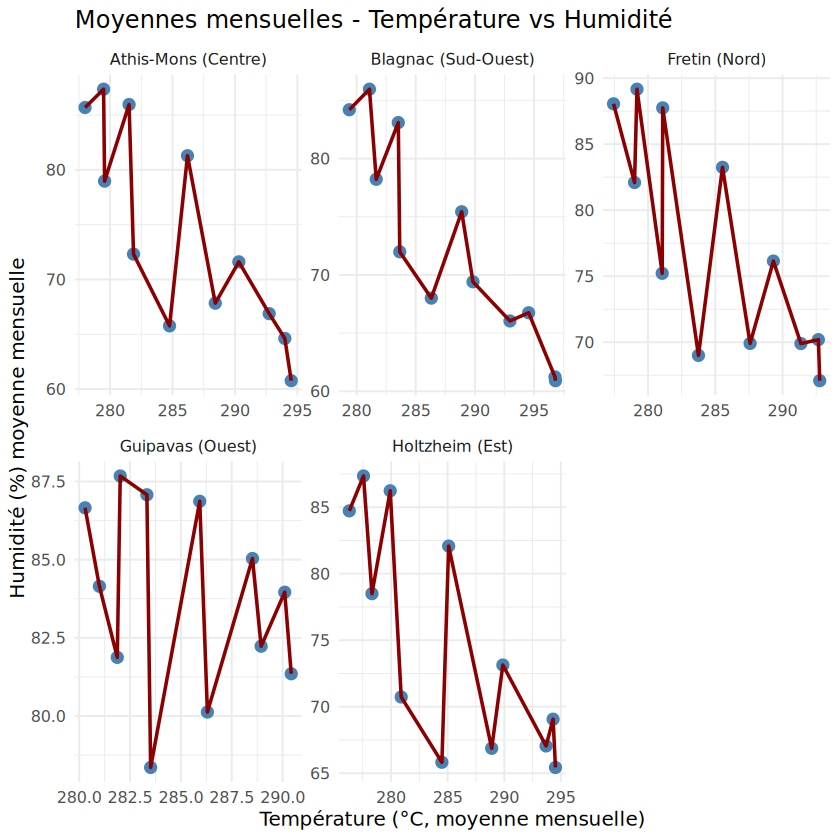

In [32]:
par(bg='white')
library(dplyr)
library(ggplot2)

stations_a_comparer <- c(7015, 7149, 7110, 7190, 7630)

# Dictionnaire ID ‚Üí Nom
station_labels <- c(
  "7015" = "Fretin (Nord)",
  "7149" = "Athis-Mons (Centre)",
  "7110" = "Guipavas (Ouest)",
  "7190" = "Holtzheim (Est)",
  "7630" = "Blagnac (Sud-Ouest)"
)

# Calculer la moyenne mensuelle par station
data_monthly <- data_metropole %>%
  filter(ID.OMM.station %in% stations_a_comparer) %>%
  group_by(ID.OMM.station, mois_de_l_annee) %>%
  summarise(
    Temp√©rature_moy = mean(Temp√©rature, na.rm = TRUE),
    Humidit√©_moy = mean(Humidit√©, na.rm = TRUE),
    .groups = "drop"
  )

# Ajouter noms des stations
data_monthly <- data_monthly %>%
  mutate(Station = recode(as.character(ID.OMM.station), !!!station_labels))

# Plot
ggplot(data_monthly, aes(x = Temp√©rature_moy, y = Humidit√©_moy)) +
  geom_point(color = "steelblue", size = 3) +
  geom_line(color = "darkred", size = 1) +
  theme_minimal(base_size = 12) +
  labs(title = "Moyennes mensuelles - Temp√©rature vs Humidit√©",
       x = "Temp√©rature (¬∞C, moyenne mensuelle)",
       y = "Humidit√© (%) moyenne mensuelle") +
  facet_wrap(~ Station, scales = "free")



`geom_smooth()` using formula = 'y ~ x'


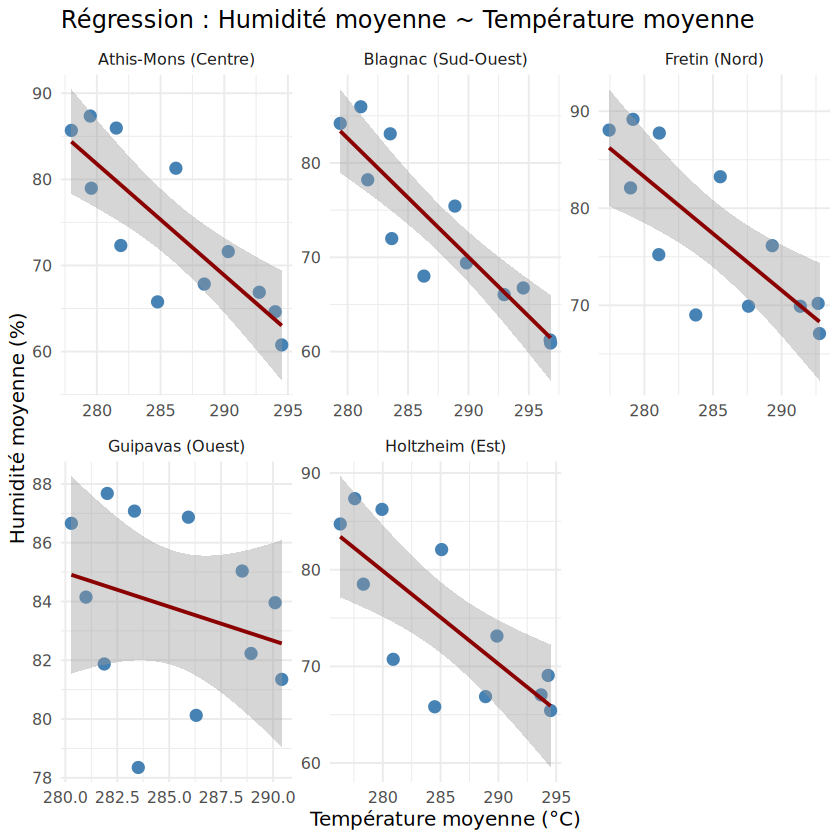

In [35]:
library(dplyr)
library(ggplot2)

stations_a_comparer <- c(7015, 7149, 7110, 7190, 7650, 7630)

# Dictionnaire ID ‚Üí Nom de station
station_labels <- c(
  "7015" = "Fretin (Nord)",
  "7149" = "Athis-Mons (Centre)",
  "7110" = "Guipavas (Ouest)",
  "7190" = "Holtzheim (Est)",
  "7650" = "Marignane (Sud-Est)",
  "7630" = "Blagnac (Sud-Ouest)"
)

# 1. Calculer les moyennes mensuelles de Temp√©rature et Humidit√© par station
data_monthly <- data_metropole %>%
  filter(ID.OMM.station %in% stations_a_comparer) %>%
  group_by(ID.OMM.station, mois_de_l_annee) %>%
  summarise(
    Temp_moy = mean(Temp√©rature, na.rm = TRUE),
    Humid_moy = mean(Humidit√©, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  # Ajouter le nom des stations
  mutate(Station = recode(as.character(ID.OMM.station), !!!station_labels))

# 2. Plot avec r√©gression lin√©aire par station
ggplot(data_monthly, aes(x = Temp_moy, y = Humid_moy)) +
  geom_point(color = "steelblue", size = 3) +
  geom_smooth(method = "lm", se = TRUE, color = "darkred") +
  theme_minimal(base_size = 12) +
  labs(title = "R√©gression : Humidit√© moyenne ~ Temp√©rature moyenne",
       x = "Temp√©rature moyenne (¬∞C)",
       y = "Humidit√© moyenne (%)") +
  facet_wrap(~ Station, scales = "free")



Les r√©gressions confirment une tendance physique attendue : hausse de la temp√©rature ‚Üî baisse de l‚Äôhumidit√© relative, avec une intensit√© diff√©rente selon les r√©gions (plus forte en climat continental, plus att√©nu√©e en climat oc√©anique).
Cependant, il faut rester prudent : l‚Äôusage de moyennes mensuelles, d‚Äôun mod√®le lin√©aire et l‚Äôabsence de prise en compte de la saisonnalit√© limitent la port√©e explicative de ces r√©sultats.

### R√©gression multiple:Visibilit√©_moy ~ Humidit√© + Temp√©rature +Pression au niveau de la mer + Pr√©cipitations au 24h

L‚Äôobjectif est de mod√©liser et d‚Äôexpliquer la visibilit√© moyenne (Visibilit√©_moy) en fonction de plusieurs param√®tres m√©t√©orologiques. 
L‚Äôid√©e est de d√©terminer quels facteurs influencent le plus la visibilit√© et d‚Äô√©valuer leur contribution relative. 

In [42]:
library(dplyr)

# ---- Pr√©paration des donn√©es ----

# 1. Ajouter ann√©e et saison
data_metropole <- data_metropole %>%
  mutate(
    annee = format(as.Date(substr(Date, 1, 10)), "%Y"),
    saison = case_when(
      mois_de_l_annee %in% c(12, 1, 2)  ~ "Hiver",
      mois_de_l_annee %in% c(3, 4, 5)   ~ "Printemps",
      mois_de_l_annee %in% c(6, 7, 8)   ~ "√ât√©",
      mois_de_l_annee %in% c(9, 10, 11) ~ "Automne"
    )
  )

# 2. Moyennes saisonni√®res par station et ann√©e
data_yearly <- data_metropole %>%
  group_by(ID.OMM.station, annee, saison) %>%
  summarise(
    Visib_moy   = mean(`Visibilit√©.horizontale`, na.rm = TRUE),
    Humid_moy   = mean(`Humidit√©`, na.rm = TRUE),
    Temp_moy    = mean(`Temp√©rature`, na.rm = TRUE),
    Pression    = mean(`Pression.au.niveau.mer`, na.rm = TRUE),
    Precip_24h  = mean(`Pr√©cipitations.dans.les.24.derni√®res.heures`, na.rm = TRUE),
    .groups = "drop"
  )

# 3. Centrer et r√©duire les pr√©dicteurs
data_yearly <- data_yearly %>%
  mutate(
    Humid_scaled    = scale(Humid_moy, center = TRUE, scale = TRUE)[,1],
    Temp_scaled     = scale(Temp_moy, center = TRUE, scale = TRUE)[,1],
    Pression_scaled = scale(Pression, center = TRUE, scale = TRUE)[,1],
    Precip_scaled   = scale(Precip_24h, center = TRUE, scale = TRUE)[,1]
  )


# A tibble: 20 √ó 6
   term            estimate std.error statistic   p.value Saison   
   <chr>              <dbl>     <dbl>     <dbl>     <dbl> <chr>    
 1 (Intercept)       27638.     1127.    24.5   7.79e- 82 Hiver    
 2 Humid_scaled      -6951.      580.   -12.0   1.82e- 28 Hiver    
 3 Temp_scaled         336.      914.     0.368 7.13e-  1 Hiver    
 4 Pression_scaled    -112.      371.    -0.302 7.63e-  1 Hiver    
 5 Precip_scaled      -216.      460.    -0.471 6.38e-  1 Hiver    
 6 (Intercept)       25130.      740.    34.0   6.58e-115 Printemps
 7 Humid_scaled      -4892.      641.    -7.63  2.13e- 13 Printemps
 8 Temp_scaled        7603.     1411.     5.39  1.27e-  7 Printemps
 9 Pression_scaled   -1083.      545.    -1.99  4.76e-  2 Printemps
10 Precip_scaled      1938.      636.     3.04  2.50e-  3 Printemps
11 (Intercept)       15684.     1730.     9.07  5.52e- 18 √ât√©      
12 Humid_scaled      -2289.      663.    -3.45  6.13e-  4 √ât√©      
13 Temp_scaled        80

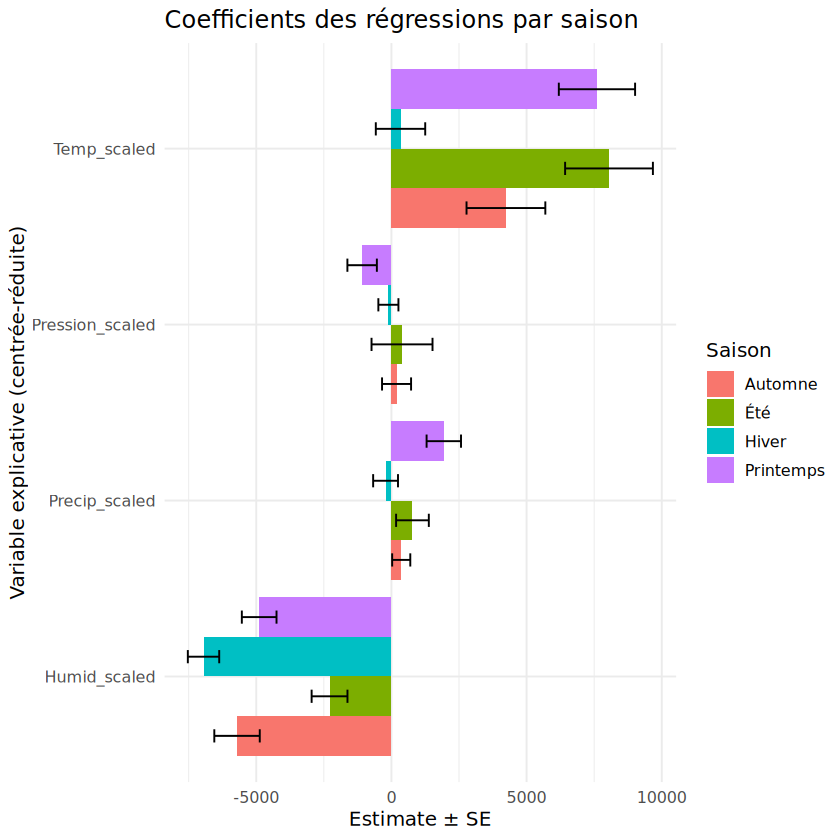

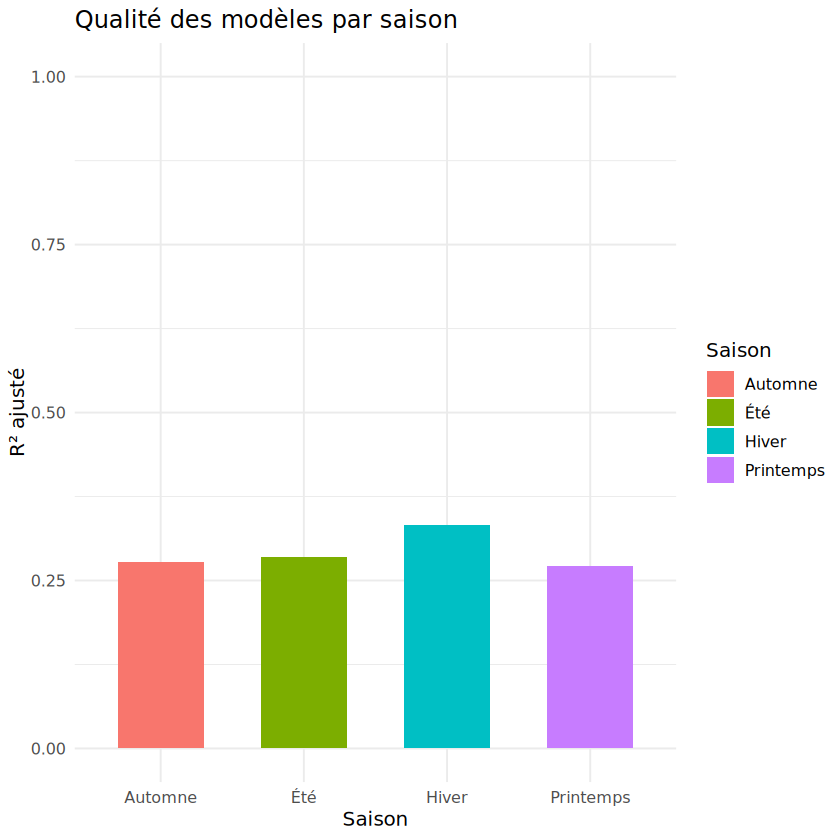

In [43]:
library(dplyr)
library(broom)   # pour tidy() et glance()

# 1. Fonction qui ajuste et retourne les r√©sultats
fit_model <- function(saison_name) {
  d <- filter(data_yearly, saison == saison_name)
  modele <- lm(Visib_moy ~ Humid_scaled + Temp_scaled + Pression_scaled + Precip_scaled,
               data = d)
  tidy_res   <- broom::tidy(modele) %>% mutate(Saison = saison_name)
  glance_res <- broom::glance(modele) %>% mutate(Saison = saison_name)
  list(tidy = tidy_res, glance = glance_res)
}

# 2. Ajuster les 4 mod√®les
res_hiver     <- fit_model("Hiver")
res_printemps <- fit_model("Printemps")
res_ete       <- fit_model("√ât√©")
res_automne   <- fit_model("Automne")

# 3. Rassembler les coefficients
coef_all <- bind_rows(res_hiver$tidy, res_printemps$tidy, 
                      res_ete$tidy, res_automne$tidy)

# 4. Rassembler les m√©triques globales (R¬≤, AIC, etc.)
stats_all <- bind_rows(res_hiver$glance, res_printemps$glance,
                       res_ete$glance, res_automne$glance)

# üëâ Afficher
print(coef_all)   # d√©tails des coefficients par saison
print(stats_all)  # qualit√© globale par saison
library(ggplot2)

# ---- 1. Plot des coefficients par saison ----
ggplot(coef_all %>% filter(term != "(Intercept)"),
       aes(x = term, y = estimate, fill = Saison)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = estimate - std.error,
                    ymax = estimate + std.error),
                position = position_dodge(width = 0.9), width = 0.3) +
  theme_minimal(base_size = 12) +
  labs(title = "Coefficients des r√©gressions par saison",
       x = "Variable explicative (centr√©e-r√©duite)",
       y = "Estimate ¬± SE") +
  coord_flip()

# ---- 2. Plot des R¬≤ ajust√©s par saison ----
ggplot(stats_all, aes(x = Saison, y = adj.r.squared, fill = Saison)) +
  geom_col(width = 0.6) +
  theme_minimal(base_size = 12) +
  labs(title = "Qualit√© des mod√®les par saison",
       x = "Saison",
       y = "R¬≤ ajust√©") +
  ylim(0, 1)


La premi√®re figure montre l‚Äôeffet des variables m√©t√©o sur la visibilit√© selon la saison.

* **Humidit√©** : impact n√©gatif net, surtout en hiver et automne (brouillard, air satur√©).
* **Temp√©rature** : effet positif marqu√© au printemps et en √©t√© (air plus sec, meilleure visibilit√©).
* **Pression et pr√©cipitations** : effets faibles ou non significatifs.

Globalement, la visibilit√© est surtout conditionn√©e par l‚Äôhumidit√© (r√©duction) et la temp√©rature (am√©lioration).

La deuxi√®me figure montre la qualit√© des mod√®les par saison via le R¬≤ ajust√©.

Commentaire concis :

Les mod√®les expliquent environ 25 √† 35 % de la variabilit√© de la visibilit√©, avec des performances l√©g√®rement meilleures en hiver. Cela indique que les variables m√©t√©o incluses (temp√©rature, humidit√©, pression, pr√©cipitations) capturent une partie de l‚Äôeffet, mais qu‚Äôune grande part de la variabilit√© reste inexpliqu√©e.

Warning message:
‚ÄúRemoved 12 rows containing missing values or values outside the scale range
(`geom_point()`).‚Äù
Warning message:
‚ÄúRemoved 11 rows containing missing values or values outside the scale range
(`geom_point()`).‚Äù
Warning message:
‚ÄúRemoved 12 rows containing missing values or values outside the scale range
(`geom_point()`).‚Äù
Warning message:
‚ÄúRemoved 12 rows containing missing values or values outside the scale range
(`geom_point()`).‚Äù


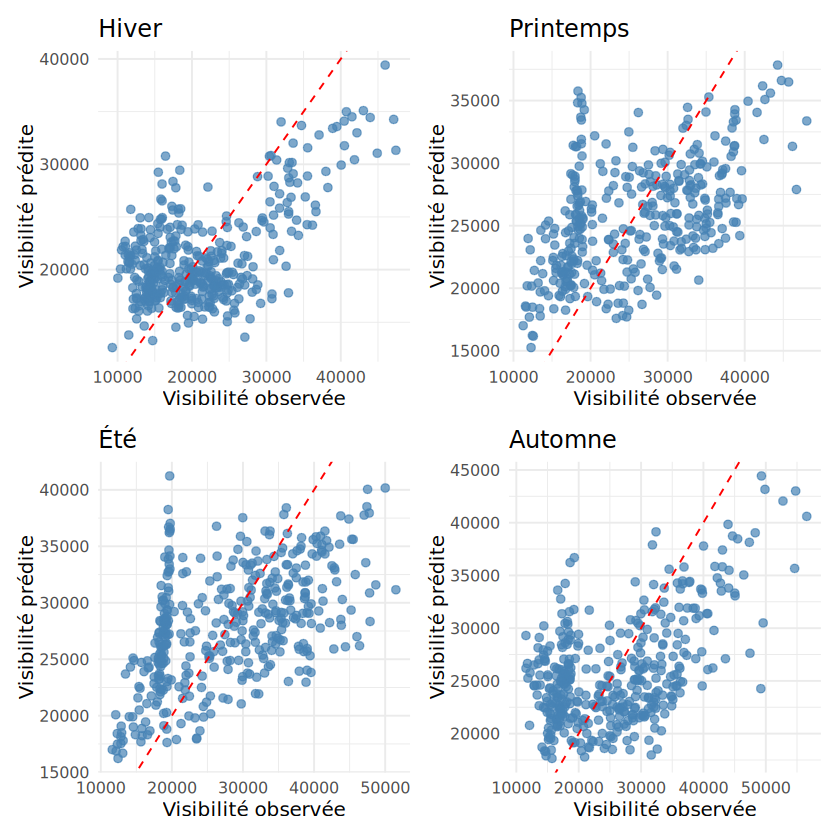

In [ ]:
# ---- Fonction pour ajuster un mod√®le et cr√©er un plot ----
fit_plot <- function(saison_name) {
  d <- filter(data_yearly, saison == saison_name)
  
  # Ajuster la r√©gression
  modele <- lm(Visib_moy ~ Humid_scaled + Temp_scaled + Pression_scaled + Precip_scaled,
               data = d)
  
  # Ajouter les pr√©dictions
  d$Pred <- predict(modele, newdata = d)
  
  # Scatter plot Observ√© vs Pr√©dit
  ggplot(d, aes(x = Visib_moy, y = Pred)) +
    geom_point(color = "steelblue", size = 2, alpha = 0.7) +
    geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
    theme_minimal(base_size = 12) +
    labs(
      title = saison_name,
      x = "Visibilit√© observ√©e",
      y = "Visibilit√© pr√©dite"
    )
}

# ---- G√©n√©rer les 4 plots ----
plot_hiver     <- fit_plot("Hiver")
plot_printemps <- fit_plot("Printemps")
plot_ete       <- fit_plot("√ât√©")
plot_automne   <- fit_plot("Automne")

# ---- Afficher en grille 2x2 ----
(plot_hiver | plot_printemps) / (plot_ete | plot_automne)


ces graphiques montrent que les mod√®les expliquent correctement la tendance g√©n√©rale de la visibilit√©,
surtout en hiver, mais restent imparfaits, avec une tendance √† sous-estimer les fortes visibilit√©s 
et une dispersion notable dans les autres saisons.